In [1]:
import os
import zipfile


In [2]:
normal_dir = os.path.join('../kaggle_data/chest_xray/train/NORMAL')
pne_dir = os.path.join('../kaggle_data/chest_xray/train/PNEUMONIA')
traincount = len(os.listdir(normal_dir)) + len(os.listdir(pne_dir))

print('total training normal images:', len(os.listdir(normal_dir)))
print('total training pneumonia images:', len(os.listdir(pne_dir)))
print('training class distribution:', len(os.listdir(pne_dir))/traincount, 'percent pneumonia |', len(os.listdir(normal_dir))/traincount, 'percent normal')

normal_files = os.listdir(normal_dir)
print(normal_files[:2])

pne_files = os.listdir(pne_dir)
print(pne_files[:2])



total training normal images: 921
total training pneumonia images: 3179
training class distribution: 0.7753658536585366 percent pneumonia | 0.22463414634146342 percent normal
['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg']
['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg']


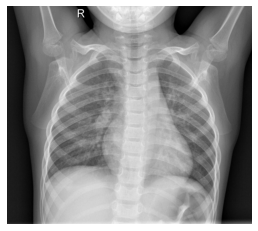

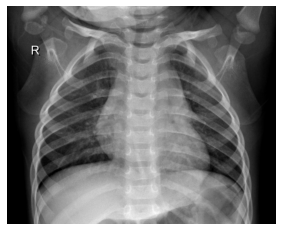

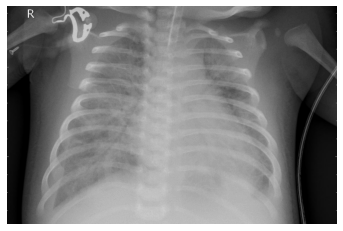

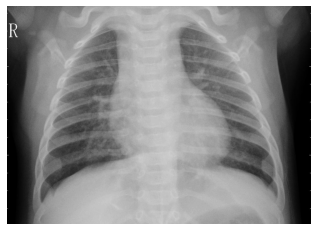

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

pic_index = 2

nextNormal = [
  os.path.join(normal_dir, fname) 
    for fname in normal_files[pic_index-2:pic_index]
]
nextPne = [
  os.path.join(pne_dir, fname) 
    for fname in pne_files[pic_index-2:pic_index]
]


for i, img_path in enumerate(nextNormal+nextPne):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img, cmap = 'gray')
  plt.axis('Off')
  plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


TRAINING_DIR = "../kaggle_data/chest_xray/train/"
training_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='reflect',
)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32,
  shuffle = True
)


VALIDATION_DIR = "../kaggle_data/chest_xray/val/"
validation_datagen = ImageDataGenerator(rescale = 1./255)


validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32,
  shuffle = True
)

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


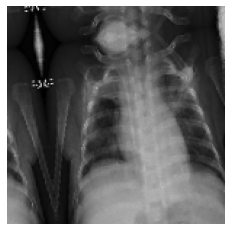

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
imgs, labels = next(train_generator)
labels[:10]
img = imgs[0]
plt.imshow(img, cmap = 'gray')
plt.axis('Off')
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2,2))
    
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (5,5), activation='relu'))
model.add(MaxPooling2D(2,2))
    
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D(2,2))   

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       3

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from datetime import datetime

estop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=13)



log_dir = '../tensorboard'
timestamp = datetime.now().strftime("%Y-%m-%d--%H%M"+'_(lung_model)')
log_dir = log_dir + '/' + timestamp

tboard = TensorBoard(log_dir=log_dir, 
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    update_freq='epoch',
                    profile_batch=2,
                    embeddings_freq=1)

cpoint = ModelCheckpoint(filepath = './lung_model_{val_accuracy: .2f}val_acc.h5', 
                         save_best_only = True, 
                         save_weights_only = False, 
                         monitor = 'val_accuracy',
                         mode = 'max')

In [9]:


history = model.fit(train_generator, 
                    epochs=100, 
                    steps_per_epoch=126, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=26,
                    callbacks = [estop, tboard, cpoint])

Epoch 1/100
126/126 [==============================] - 76s 606ms/step - loss: 0.5798 - accuracy: 0.7687 - val_loss: 0.7155 - val_accuracy: 0.4916
Epoch 2/100
126/126 [==============================] - 75s 599ms/step - loss: 0.4841 - accuracy: 0.7775 - val_loss: 0.8965 - val_accuracy: 0.4988
Epoch 3/100
126/126 [==============================] - 76s 599ms/step - loss: 0.4677 - accuracy: 0.7745 - val_loss: 0.7373 - val_accuracy: 0.5096
Epoch 4/100
126/126 [==============================] - 75s 598ms/step - loss: 0.4714 - accuracy: 0.7757 - val_loss: 0.9135 - val_accuracy: 0.4976
Epoch 5/100
126/126 [==============================] - 76s 603ms/step - loss: 0.4589 - accuracy: 0.7735 - val_loss: 0.7097 - val_accuracy: 0.5012
Epoch 6/100
126/126 [==============================] - 76s 602ms/step - loss: 0.4466 - accuracy: 0.7742 - val_loss: 0.6653 - val_accuracy: 0.4976
Epoch 7/100
126/126 [==============================] - 76s 600ms/step - loss: 0.4344 - accuracy: 0.7762 - val_loss: 0.7849 -

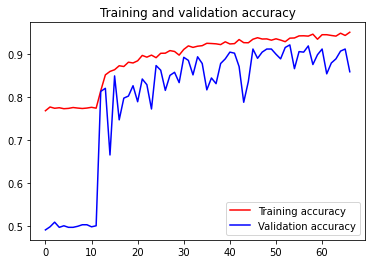

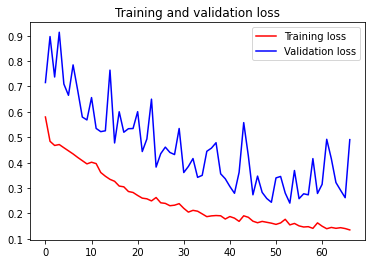

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [11]:
print(log_dir)

C:\Users\ronit\AI\kaggle_ml\tensorboard\2020-06-24--2033_(lung_model)


In [19]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("./lung_model_ 0.93val_acc.h5", compile=True)

#Find accuracy per class
testdir = "../kaggle_data/chest_xray/test"
testgen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
  testdir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=439,
  shuffle = True
)
print(testgen.class_indices)
correct = [0, 0]
total = [0, 0]
for i in range(0, 2):
  imges, labels = next(testgen)
  labels = [(0 if labels[i][0] == 1 else 1) for i in range(0, len(labels))]

  preds = model.predict(imges)
  classes = np.argmax(preds, axis=1)
  # print(classes)
  # print(labels)
  for i in range(0, len(classes)):
    total[labels[i]] += 1
    if labels[i] == classes[i]:
      correct[classes[i]] += 1
print(f"NORMAL ACC: {float(correct[0]/total[0])}, {total[0]} imgs")
print(f"PNEUMONIA ACC: {float(correct[1]/total[1])}, {total[1]} imgs")

  # for j in range(0, len(imgs)):
  #   preds = model.predict(imgs[0])
  #   classes = np.argmax(preds, axis=1)
  #   print(classes)
  #   break

Found 878 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
NORMAL ACC: 0.9134396355353075, 439 imgs
PNEUMONIA ACC: 0.9567198177676538, 439 imgs
